In [6]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.nn.functional as F
import matplotlib.pyplot as plt

def int_to_one_hot_tensor(x):
    return F.one_hot(torch.tensor(x), num_classes=10)

training_data = datasets.MNIST(
    root="data",
    train=True,
    download=False,
    transform=ToTensor(),
    target_transform=int_to_one_hot_tensor
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=False,
    transform=ToTensor(),
    target_transform=int_to_one_hot_tensor
)

input_layer_size = len(training_data[0][0].squeeze().flatten())
g = torch.Generator().manual_seed(42)

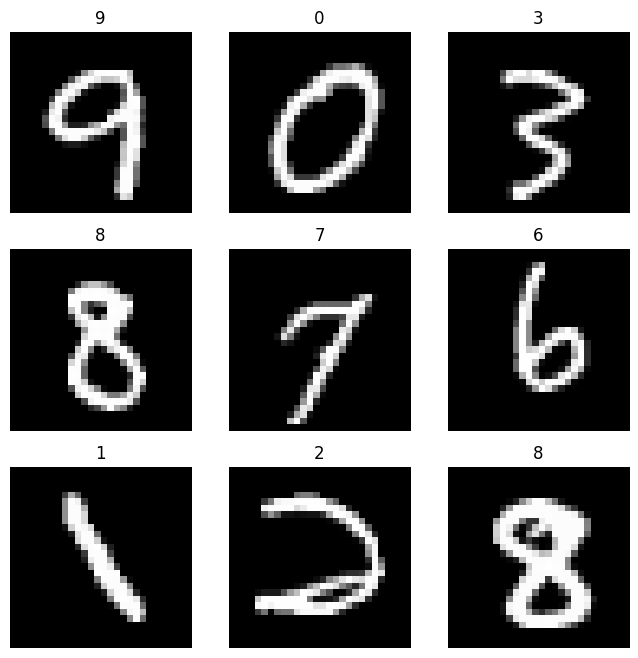

In [7]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(torch.argmax(label).item())
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [134]:
WL1 = torch.randn((input_layer_size, 32), generator=g)
WL2 = torch.randn((32, 10), generator=g)
parameters = [WL1, WL2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

25408


In [135]:
loss_snapshot = []
acc_snapshot = []
step = []
snapshot_filter = 100
snapshot_counter = snapshot_filter
optim = torch.optim.Adam(parameters, lr=0.001)
for i in range(0, 2000):
    train_features, train_labels = next(iter(train_dataloader))
    X = train_features.squeeze().reshape(-1, input_layer_size)
    L1 = torch.tanh(X @ WL1)
    L2 = L1 @ WL2
    loss = F.cross_entropy(L2, train_labels.float())
    optim.zero_grad()
    loss.backward()
    optim.step()
    if snapshot_counter == 0:
        step.append(i)
        loss_snapshot.append(loss.item())
        softmax = torch.exp(F.log_softmax(L2, dim=1))
        acc = torch.mean(100*(1 - torch.sum((train_labels - (softmax * train_labels)), dim=1)))
        acc_snapshot.append(acc.item())
        snapshot_counter = snapshot_filter
    else:
        snapshot_counter -= 1

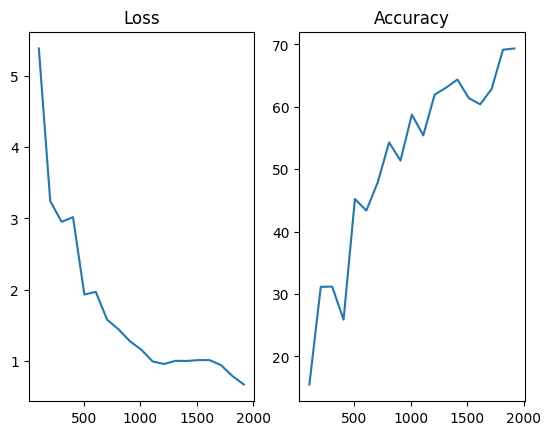

In [136]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title("Loss")
ax1.plot(step, loss_snapshot)
ax2.set_title("Accuracy")
ax2.plot(step, acc_snapshot)

plt.show()

In [137]:
test_loss_snapshot = []
test_acc_snapshot = []
for i in range(0, 100):
    test_features, test_labels = next(iter(test_dataloader))
    X = test_features.squeeze().reshape(-1, input_layer_size)
    L1 = torch.tanh(X @ WL1)
    L2 = L1 @ WL2
    loss = F.cross_entropy(L2, test_labels.float())
    test_loss_snapshot.append(loss.item())
    softmax = torch.exp(F.log_softmax(L2, dim=1))
    acc = torch.mean(100*(1 - torch.sum((test_labels - (softmax * test_labels)), dim=1)))
    test_acc_snapshot.append(acc.item())

print("loss: ", sum(test_loss_snapshot)/len(test_loss_snapshot))
print("acc: ", sum(test_acc_snapshot)/len(test_acc_snapshot))

loss:  0.7420830434560776
acc:  71.17854400634765


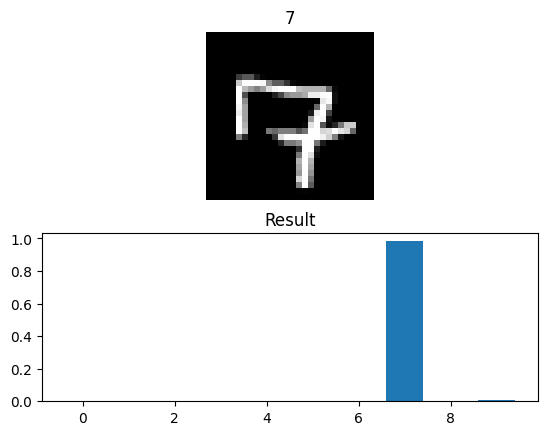

In [181]:
test_features, test_labels = next(iter(test_dataloader))
X = test_features.squeeze().reshape(-1, input_layer_size)
L1 = torch.tanh(X @ WL1)
L2 = L1 @ WL2
softmax = [s.item() for s in torch.exp(F.log_softmax(L2, dim=1)[0])]
img = test_features[0].squeeze()

fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.set_title(torch.argmax(test_labels[0]).item())
ax1.axis("off")
ax1.imshow(img, cmap="gray")
ax2.set_title("Result")
number_labels = range(0, 10)
ax2.bar(number_labels, softmax)
plt.show()